# Introduction to a DESI Spectroscopic Data Release

### Overview
This notebook borrows a lot from (but updates and builds on) "Intro_to_DESI_SV_spectra.ipynb".

The goal of this notebook is to demonstrate how to read in and manipulate DESI on-sky data using the internal Denali release as an exmaple. Since Denali only included data through March 31st, 2021, this will do a worked example on a deep SV1 tile. However, the files and methods will apply equally well to upcoming releases with 1% survey data and main survey data.


### Bug Reporting
If you identify any errors or have requests for additional functionality please create a new issue at https://github.com/desihub/tutorials/issues or send a note to desi-data@desi.lbl.gov.

### Update Tracking
Last updated June 2022 using the 22.2 software release.

## Getting started

### Using NERSC

The easiest way to get started is to use the jupyter server at NERSC so that you don't need to
install any code or download any data locally.

If you need a NERSC account, see https://desi.lbl.gov/trac/wiki/Computing/AccessNersc

Then do the one-time jupyter configuration described at https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC

From a NERSC command line, checkout a copy of the tutorial code, *e.g.* from cori.nersc.gov
```console
mkdir -p $HOME/desi/
cd $HOME/desi/
git clone https://github.com/desihub/tutorials
```
And then go to https://jupyter.nersc.gov, login, navigate to where you checked out this package (*e.g.* `$HOME/desi/tutorials`), and double-click on `Intro_to_a_DESI_Release.ipynb`.

This tutorial has been tested using the "DESI 21.5" kernel installed at NERSC. If you don't see that installed, you will need to open a terminal either in jupyterhub or via an actual terminal and do the following:

```console
source /global/common/software/desi/cori/desiconda/startup/modulefiles/desimodules/install_jupyter_kernel.sh 22.2
```
You'll then need to restart your jupyterhub in order to see the kernel.


To get an equivalent environment from a cori command line:
```console
source /global/common/software/desi/desi_environment.sh 22.2
```

## Import required modules

In [1]:
import os
import numpy as np
import healpy as hp
from glob import glob
from astropy.table import Table
from astropy.io import fits
import fitsio
from collections import defaultdict

## Import desi targeting bitmask definitions
## We won't use anything other than SV1 bits, but it's worth knowing the others are there
from desitarget.sv1 import sv1_targetmask
#from desitarget.cmx import cmx_targetmask
#from desitarget.sv2 import sv2_targetmask
#from desitarget.sv3 import sv3_targetmask  
#from desitarget import targetmask # main survey bits

## Import so we have access to a helper utility for opening desi spectra files
import desispec.io

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


If you are running locally and any of these fail, 
you should go back through the [installation instructions](https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop) and/or email `desi-data@desi.lbl.gov` if you get stuck.
If you are running from jupyter.nersc.gov and have problems, double check that your kernel is "DESI 21.5".

## Environment variables and data

DESI uses environment variables to define the base directories for where to find data.  The below paths are for NERSC, but if you are running locally or want to access a different dataset, change these as needed to wherever your dataset is.

Spectro production runs are grouped under `$DESI_SPECTRO_REDUX`, with `$SPECPROD` indicating which run to use, such that the data are under `$DESI_SPECTRO_REDUX/$SPECPROD`.  *e.g.* during operations, official productions will be in `$DESI_SPECTRO_REDUX=/global/cfs/cdirs/desi/spectro/redux` and `$SPECPROD` would be the name for individual data releases, *e.g.* `$SPECPROD=blanc`.  In this case, we'll use `$SPECPROD=denali`, which is the most recent release from April 2021.

In [2]:
%set_env DESI_SPECTRO_REDUX=/global/cfs/cdirs/desi/spectro/redux
%set_env SPECPROD=fuji

env: DESI_SPECTRO_REDUX=/global/cfs/cdirs/desi/spectro/redux
env: SPECPROD=fuji


In [35]:
#- Do check that these are set correctly before proceeding
def check_env():
    for env in ('DESI_SPECTRO_REDUX', 'SPECPROD'):
        if env in os.environ:
            print('${}={}'.format(env, os.getenv(env)))
        else:
            print('Required environment variable {} not set!'.format(env))

    reduxdir = desispec.io.specprod_root()
    if not os.path.exists(reduxdir):
        print("ERROR: {} doesn't exist; check $DESI_SPECTRO_REDUX/$SPECPROD".format(reduxdir))
    else:
        print('OK: {} exists'.format(reduxdir))

check_env()

$DESI_SPECTRO_REDUX=/global/cfs/cdirs/desi/spectro/redux
$SPECPROD=fuji
OK: /global/cfs/cdirs/desi/spectro/redux/fuji exists


`desispec.io.specprod_root` can handle the environment variable path wrangling for you:

In [4]:
reduxdir = desispec.io.specprod_root()
print(reduxdir)

/global/cfs/cdirs/desi/spectro/redux/fuji


## Summary Files

Let's take a look around the directory and open some of the files sitting in the top level

In [5]:
os.chdir(reduxdir)

In [6]:
sorted(os.listdir())

['calibnight',
 'exposure_tables',
 'exposures',
 'exposures-fuji.csv',
 'exposures-fuji.fits',
 'healpix',
 'preproc',
 'processing_tables',
 'redux_fuji.sha256sum',
 'run',
 'tiles',
 'tiles-fuji.csv',
 'tiles-fuji.fits',
 'zcatalog']

### tiles-denali.csv
This file tells you what tiles were observed, what survey and program they were observed for, where they observed on the sky, some obseving conditions, and three estimates of the "effective time" (in seconds) that each tile acquired. The time estimate used for sur ey operations decisions is `EFFTIME_SPEC`.

For the main survey `ZDONE` will determine whether the tile was successfully observed to sufficient depth to be considered done observing. For SV that is still generally true.

In [36]:
tiles_tab = Table.read('tiles-fuji.csv',format='ascii.csv')
print(f"Tiles table columns: {tiles_tab.colnames}")
tiles_tab[-10:].show_in_notebook()

Tiles table columns: ['TILEID', 'SURVEY', 'PROGRAM', 'FAPRGRM', 'FAFLAVOR', 'NEXP', 'EXPTIME', 'TILERA', 'TILEDEC', 'EFFTIME_ETC', 'EFFTIME_SPEC', 'EFFTIME_GFA', 'GOALTIME', 'OBSSTATUS', 'LRG_EFFTIME_DARK', 'ELG_EFFTIME_DARK', 'BGS_EFFTIME_BRIGHT', 'LYA_EFFTIME_DARK', 'GOALTYPE', 'MINTFRAC', 'LASTNIGHT']


idx,TILEID,SURVEY,PROGRAM,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT
0,49,sv3,bright,bright,sv3bright,1,1050.9,179.691,-0.078,222.5,285.3,283.0,220.0,obsend,280.4,275.4,285.3,175.2,bright,0.9,20210529
1,184,sv3,bright,bright,sv3bright,1,389.1,215.546,52.383,226.9,250.7,271.7,220.0,obsend,250.8,264.9,250.7,182.6,bright,0.9,20210529
2,346,sv3,bright,bright,sv3bright,1,1146.0,241.016,43.333,220.6,341.0,306.9,220.0,obsend,347.9,386.0,341.0,152.8,bright,0.9,20210529
3,400,sv3,bright,bright,sv3bright,1,939.0,252.442,34.39,223.2,324.4,290.9,220.0,obsend,330.7,368.8,324.4,157.6,bright,0.9,20210529
4,265,sv3,bright,bright,sv3bright,2,2180.0,219.819,-0.718,222.2,347.5,319.4,220.0,obsend,348.9,387.2,347.5,134.9,bright,0.9,20210529
5,596,sv3,backup,backup,sv3backup,1,142.2,236.1,43.57,68.5,84.5,107.8,30.0,obsend,77.8,82.3,80.6,43.6,backup,0.9,20210529
6,402,sv3,backup,backup,sv3backup,1,345.6,252.362,34.538,61.2,81.6,79.9,30.0,obsend,98.8,109.3,99.5,34.8,backup,0.9,20210529
7,504,sv3,bright,bright,sv3bright,1,384.3,194.619,24.683,231.5,268.5,280.7,220.0,obsend,272.1,267.1,268.5,174.3,bright,0.9,20210529
8,76,sv3,bright,bright,sv3bright,1,761.3,183.186,-0.083,225.2,283.0,297.0,220.0,obsend,284.5,281.2,283.0,184.0,bright,0.9,20210529
9,521,sv3,dark,dark,sv3dark,1,1378.7,212.891,-0.679,1211.8,1227.0,1196.3,1200.0,obsend,1285.5,1227.0,1209.1,1084.5,dark,0.9,20210610


### tsnr-denali.csv
This file is primarily used for daily operations, but can be handy for looking at individual exposures and the amount of "EFFECTIVE TIME" that exposure acquired.

In [37]:
tsnr_tab = Table.read('tiles-fuji.fits',format='fits')
print(f"Tiles table columns: {tsnr_tab.colnames}")
tsnr_tab[-10:].show_in_notebook()

Tiles table columns: ['TILEID', 'SURVEY', 'PROGRAM', 'FAPRGRM', 'FAFLAVOR', 'NEXP', 'EXPTIME', 'TILERA', 'TILEDEC', 'EFFTIME_ETC', 'EFFTIME_SPEC', 'EFFTIME_GFA', 'GOALTIME', 'OBSSTATUS', 'LRG_EFFTIME_DARK', 'ELG_EFFTIME_DARK', 'BGS_EFFTIME_BRIGHT', 'LYA_EFFTIME_DARK', 'GOALTYPE', 'MINTFRAC', 'LASTNIGHT']


idx,TILEID,SURVEY,PROGRAM,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT
0,49,sv3,bright,bright,sv3bright,1,1050.9,179.691,-0.078,222.5,285.3,283.0,220.0,obsend,280.4,275.4,285.3,175.2,bright,0.9,20210529
1,184,sv3,bright,bright,sv3bright,1,389.1,215.546,52.383,226.9,250.7,271.7,220.0,obsend,250.8,264.9,250.7,182.6,bright,0.9,20210529
2,346,sv3,bright,bright,sv3bright,1,1146.0,241.016,43.333,220.6,341.0,306.9,220.0,obsend,347.9,386.0,341.0,152.8,bright,0.9,20210529
3,400,sv3,bright,bright,sv3bright,1,939.0,252.442,34.39,223.2,324.4,290.9,220.0,obsend,330.7,368.8,324.4,157.6,bright,0.9,20210529
4,265,sv3,bright,bright,sv3bright,2,2180.0,219.819,-0.718,222.2,347.5,319.4,220.0,obsend,348.9,387.2,347.5,134.9,bright,0.9,20210529
5,596,sv3,backup,backup,sv3backup,1,142.2,236.1,43.57,68.5,84.5,107.8,30.0,obsend,77.8,82.3,80.6,43.6,backup,0.9,20210529
6,402,sv3,backup,backup,sv3backup,1,345.6,252.362,34.538,61.2,81.6,79.9,30.0,obsend,98.8,109.3,99.5,34.8,backup,0.9,20210529
7,504,sv3,bright,bright,sv3bright,1,384.3,194.619,24.683,231.5,268.5,280.7,220.0,obsend,272.1,267.1,268.5,174.3,bright,0.9,20210529
8,76,sv3,bright,bright,sv3bright,1,761.3,183.186,-0.083,225.2,283.0,297.0,220.0,obsend,284.5,281.2,283.0,184.0,bright,0.9,20210529
9,521,sv3,dark,dark,sv3dark,1,1378.7,212.891,-0.679,1211.8,1227.0,1196.3,1200.0,obsend,1285.5,1227.0,1209.1,1084.5,dark,0.9,20210610


In [46]:
"""
survey_types = set()
for survey in tsnr_tab["SURVEY"]:
    survey_types.add(survey)
print(survey_types)
"""
for survey in ['sv3', 'sv2', 'sv1', 'cmx', 'special']:
    print(f'{survey}: Ntiles={np.sum(tsnr_tab["SURVEY"]==survey)}')


sv3: Ntiles=488
sv2: Ntiles=39
sv1: Ntiles=188
cmx: Ntiles=1
special: Ntiles=16


### zcatalog-denali-cumulative.fits
This file contains all of the cumulative redshifts (spectra coadded across all available nights) for all of Denali. The table columns come from the `zbest` files combined with their `fibermaps` from the corresponding coadd file.

In [49]:
zcat_tab = Table.read('zcatalog/zall-tilecumulative-fuji.fits',format='fits')
# zcat_tab = Table.read('zcatalog/zall-pix-fuji.fits',format='fits')
print(f"Tiles table columns: {zcat_tab.colnames}")
zcat_tab[-10:].show_in_notebook()

Tiles table columns: ['TARGETID', 'SURVEY', 'PROGRAM', 'LASTNIGHT', 'SPGRPVAL', 'Z', 'ZERR', 'ZWARN', 'CHI2', 'COEFF', 'NPIXELS', 'SPECTYPE', 'SUBTYPE', 'NCOEFF', 'DELTACHI2', 'PETAL_LOC', 'DEVICE_LOC', 'LOCATION', 'FIBER', 'COADD_FIBERSTATUS', 'TARGET_RA', 'TARGET_DEC', 'PMRA', 'PMDEC', 'REF_EPOCH', 'LAMBDA_REF', 'FA_TARGET', 'FA_TYPE', 'OBJTYPE', 'FIBERASSIGN_X', 'FIBERASSIGN_Y', 'PRIORITY', 'SUBPRIORITY', 'OBSCONDITIONS', 'RELEASE', 'BRICKNAME', 'BRICKID', 'BRICK_OBJID', 'MORPHTYPE', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'FIBERTOTFLUX_G', 'FIBERTOTFLUX_R', 'FIBERTOTFLUX_Z', 'MASKBITS', 'SERSIC', 'SHAPE_R', 'SHAPE_E1', 'SHAPE_E2', 'REF_ID', 'REF_CAT', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_PHOT_BP_MEAN_MAG', 'GAIA_PHOT_RP_MEAN_MAG', 'PARALLAX', 'PHOTSYS', 'PRIORITY_INIT', 'NUMOBS_INIT', 'CMX_TARGET', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'SCND_TAR

idx,TARGETID,SURVEY,PROGRAM,LASTNIGHT,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF [10],NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,SV_NSPEC,SV_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY
0,39633145208767589,sv3,dark,20210513,20210513,1.032475042328646,5.9279939283054296e-05,4,7612.679979085922,-53.86617468823678 .. -0.6838371311489707,7829,GALAXY,--,10,4.995253920555115,3,301,3301,1670,0,234.5941353920294,43.673469768176226,0.0,0.0,2015.5,5400.0,4674,1,TGT,293.92245,77.471436,83100,0.9278211277472957,1,9011,2346p437,559830,1125,PSF,0.022726411,0.33474073,0.24695498,0.32108232,0.6272713,0.6479462,264.19315,137.96964,69.48887,6.1052623,1.6070596,0.26073015,0.19235368,0.2500916,0.26073015,0.19235368,0.2500916,0,0.0,0.0,0.0,0.0,0,--,0.0,0.0,0.0,0.0,N,103100,3,0,0,0,0,0,0,0,0,0,0,0,0,0,4674,0,0,0,234.5941353920294,43.673469768176226,581,1,981.8098,1,1,0.004,0.004,0.006,0.006,234.5941568446484,0.0,43.673446177792286,0.0,0.789,293.89,77.447,250.92696,0.17699666,43.05123,121.41313,868.36835,296.13324,4.873459,1.8950672,18898.453,39.628315,2989.0679,0.107480645,3391.0574,17359.512,12.649624,56.839027,4.187917e-05,121.555984,6.985826e-06,0.0,5455.75,4.5499746e-05,27.333311,60.075024,19149.38,161.3613,3032.1191,121.520615,9715.176,17655.645,44.85639,118.80911,3,False,3,False
1,39633145208768190,sv3,dark,20210513,20210513,0.1197736570277991,4.71113360442914e-06,0,7664.184164404869,434.5200766092179 .. 22.171231739884504,7854,GALAXY,--,10,1622.674692749977,3,304,3304,1668,0,234.65004356847484,43.790314877870415,0.0,0.0,2015.5,5400.0,4611686018427387904,1,TGT,283.31485,106.3756,70,0.5891621907428555,63,0,--,0,0,--,0.0,5.525963,8.055081,10.312717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,--,0.0,0.0,0.0,0.0,--,70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4611686018427387904,0,0,65536,234.65004356847484,43.790314877870415,581,1,981.8098,1,1,0.003,0.003,0.007,0.007,234.65005965268944,0.0,43.790287274359535,0.0,0.7923119,283.286,106.347,285.22363,0.20935458,48.83318,147.67723,1017.538,333.95566,5.776313,2.2003598,21056.098,43.822517,3321.2075,0.12093388,3771.5476,19176.62,14.0307455,62.96521,4.682921e-05,131.66719,7.781175e-06,0.0,5919.757,5.023912e-05,29.67936,65.419426,21341.32,175.69907,3370.0408,147.79817,10708.842,19510.574,49.48642,130.58499,1,True,1,True
2,39633145208769271,sv3,dark,20210513,20210513,0.7427824475161716,6.732852945173265e-05,4,7780.609942212701,9.487312353923402 .. -7.937944570100079,7873,GALAXY,--,10,5.896884583868086,3,288,3288,1667,0,234.75641980880

## Data Model for the spectra

### Directory structure

Spectra from individual exposures are in the `exposures` directory.  But since SV will focus on targeting individual _tiles_, the relevant directory and file structure is: 

```
$DESI_SPECTRO_REDUX/$SPECPROD/tiles/$GROUP/$TILE/$DATE/*-$SPECTROGRAPH-$TILE-${GROUPPREFIX}$DATE.fits
```

where:
* `$GROUP` is cumulative, perexp, or pernight. It tells you whether the redshifts are: based on the cumulative coadd of all spectra up-to-and-including the listed night, based on individual exposures, or based on coadds of from data only on a given night.
* `$TILE` is the number of the relevant SV or main survey tile. For example, for SV1, see the list of tiles on the SV1 [wiki page](https://desi.lbl.gov/trac/wiki/SurveyValidation/SV1).
* `$DATE` is the date expressed as YYYYMMDD, for example 20210318 for year=2021, month=March, day=18.
* `$SPECTROGRAPH` corresponds to the DESI spectrograph used to observe the targets (0-9).
* `$GROUPPREFIX` is either "thru" for cumulative, "exp" for perexp, or nothing for pernight.

The files we will focus on for most of this tutorial correspond to `$TILE=80698` and `$DATE=20210318` and `$SPECTROGRAPH=0`. For example:

```
$DESI_SPECTRO_REDUX/$SPECPROD/tiles/cumulative/80698/20210318/coadd-0-80698-20210318.fits
$DESI_SPECTRO_REDUX/$SPECPROD/tiles/cumulative/80698/20210318/zbest-0-80698-20210318.fits
```
where the first file contains the (coadded) spectra and the second file contains information on the best-fit redshifts from the [redrock](https://github.com/desihub/redrock) code.

Let's look around in these directories.

In [50]:
basedir = os.path.join(reduxdir, "tiles")
groupdirs = sorted(os.listdir(basedir))
print(basedir)
print(groupdirs)

/global/cfs/cdirs/desi/spectro/redux/fuji/tiles
['1x_depth', '4x_depth', 'cumulative', 'lowspeed', 'perexp', 'pernight']


In [51]:
groupdir = os.path.join(basedir, groupdirs[2])
subdirs = sorted(os.listdir(groupdir))
print(groupdir)
print(subdirs)

/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative
['1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '131', '132', '133', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '158', '16', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '20', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '21', '210', '211', '212', '213', '214', '215', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '23', '230', '231', '232', '233'

In [52]:
tiledir = os.path.join(groupdir, subdirs[2])
nightdirs = sorted(os.listdir(tiledir))
print(tiledir)
print(nightdirs)

/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/100
['20210505']


In [53]:
nightdir = os.path.join(tiledir,nightdirs[0])
coaddfiles = sorted(glob(os.path.join(nightdir, "*coadd*.fits")))
zbestfiles = sorted(glob(os.path.join(nightdir, "*redrock*.fits")))

print(nightdir,'\n')
print([os.path.basename(fil) for fil in coaddfiles],'\n')
print([os.path.basename(fil) for fil in zbestfiles])

/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/100/20210505 

['coadd-0-100-thru20210505.fits', 'coadd-1-100-thru20210505.fits', 'coadd-2-100-thru20210505.fits', 'coadd-3-100-thru20210505.fits', 'coadd-4-100-thru20210505.fits', 'coadd-5-100-thru20210505.fits', 'coadd-6-100-thru20210505.fits', 'coadd-7-100-thru20210505.fits', 'coadd-8-100-thru20210505.fits', 'coadd-9-100-thru20210505.fits'] 

['redrock-0-100-thru20210505.fits', 'redrock-1-100-thru20210505.fits', 'redrock-2-100-thru20210505.fits', 'redrock-3-100-thru20210505.fits', 'redrock-4-100-thru20210505.fits', 'redrock-5-100-thru20210505.fits', 'redrock-6-100-thru20210505.fits', 'redrock-7-100-thru20210505.fits', 'redrock-8-100-thru20210505.fits', 'redrock-9-100-thru20210505.fits']


### Looking at the data for a tile

Lets look at the fifth deepest tile

In [58]:
tiles_tab.sort('EFFTIME_SPEC',reverse=True)
tile_info = tiles_tab[4]
tile, last_night = tile_info['TILEID'], tile_info['LASTNIGHT']
print(f"TileID: \t{tile}\nLAST_NIGHT: \t{last_night}")

TileID: 	80871
LAST_NIGHT: 	20210430


##### Let's see if the LAST_NIGHT matches the directory

In [59]:
os.listdir(os.path.join(reduxdir,'tiles','cumulative',str(tile)))

['20210430']

It matches! Now before we look at the data in that directory, let's be courteous with the shared jupyterhub resources and give back the memory from those catalogs we loaded before:

In [60]:
del tiles_tab, tsnr_tab, zcat_tab

## spectra file format

What about the Data Model for the coadded spectra themselves?

In [66]:
path_template = os.path.join(reduxdir,'tiles','cumulative','{tileid}','{night}')
coadd_template = "coadd-{spectrograph}-{tileid}-thru{night}.fits"
print("Path template:",path_template)
print("File template:",coadd_template)

coadd_pathname_template = os.path.join(path_template,coadd_template)
print("Combining:",coadd_pathname_template)

Path template: /global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/{tileid}/{night}
File template: coadd-{spectrograph}-{tileid}-thru{night}.fits
Combining: /global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/{tileid}/{night}/coadd-{spectrograph}-{tileid}-thru{night}.fits


In [68]:
fits

<module 'astropy.io.fits' from '/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/astropy/io/fits/__init__.py'>

In [67]:
example_spectrograph = 4
coadfilename = coadd_pathname_template.format(spectrograph=example_spectrograph, tileid=tile, night=last_night)
coadd = fits.open(coadfilename)
coadd.info()

Filename: /global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/80871/20210430/coadd-4-80871-thru20210430.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      61   ()      
  1  FIBERMAP      1 BinTableHDU    219   500R x 81C   [K, I, J, K, J, J, D, D, E, E, E, E, K, B, 3A, E, E, J, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, K, K, K, D, D, J, I, E, I, I, E, E, E, E, D, E, D, E, E, E, E]   
  2  EXP_FIBERMAP    1 BinTableHDU     64   9500R x 26C   [K, J, D, J, J, D, J, D, I, J, K, J, J, E, E, E, D, D, K, D, D, D, D, D, D, D]   
  3  B_WAVELENGTH    1 ImageHDU        10   (2751,)   float64   
  4  B_FLUX        1 ImageHDU        11   (2751, 500)   float32   
  5  B_IVAR        1 ImageHDU        11   (2751, 500)   float32   
  6  B_MASK        1 ImageHDU        12   (2751, 500)   int32 (rescales to uint32)   
  7  B_RESOLUTION    1 ImageHDU        

HDU 0 is blank.  The others should be used by name, not by number since the order could vary.

`FIBERMAP` stores the mapping of the imaging information used to target and place a fiber on the source.

The other HDUs contain the wavelength arrays, flux, inverse variance (ivar), mask (0 is good), and spectral resolution data coadded across each of the "B", "R", and "Z" cameras.

Let's start by looking at the fibermap.

In [74]:
fm = Table(coadd['FIBERMAP'].data)
fm.colnames

['TARGETID',
 'PETAL_LOC',
 'DEVICE_LOC',
 'LOCATION',
 'FIBER',
 'COADD_FIBERSTATUS',
 'TARGET_RA',
 'TARGET_DEC',
 'PMRA',
 'PMDEC',
 'REF_EPOCH',
 'LAMBDA_REF',
 'FA_TARGET',
 'FA_TYPE',
 'OBJTYPE',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y',
 'PRIORITY',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'RELEASE',
 'BRICKNAME',
 'BRICKID',
 'BRICK_OBJID',
 'MORPHTYPE',
 'EBV',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'MASKBITS',
 'SERSIC',
 'SHAPE_R',
 'SHAPE_E1',
 'SHAPE_E2',
 'REF_ID',
 'REF_CAT',
 'GAIA_PHOT_G_MEAN_MAG',
 'GAIA_PHOT_BP_MEAN_MAG',
 'GAIA_PHOT_RP_MEAN_MAG',
 'PARALLAX',
 'PHOTSYS',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'SV1_DESI_TARGET',
 'SV1_BGS_TARGET',
 'SV1_MWS_TARGET',
 'SV1_SCND_TARGET',
 'DESI_TARGET',
 'BGS_TARGET',
 'MWS_TARGET',
 'PLATE_RA',
 'PLATE_DEC',
 'TILEID',
 'COADD_NUME

`TARGETID` is the unique mapping from target information to a fiber. So, if you wanted to look up full imaging information for a spectrum, you can map back to target files using `TARGETID`.

The remaining extensions store the wavelength, flux, inverse variance on the flux, mask and resolution matrix coadded for the B, R and Z arms of the spectrograph. Let's check that the full wavelength coverage across all 3 arms of each of the DESI spectrographs is the same:

As we are only looking at a single spectrograph this should correspond to a single petal in the DESI focal plane. I wonder if that's true?

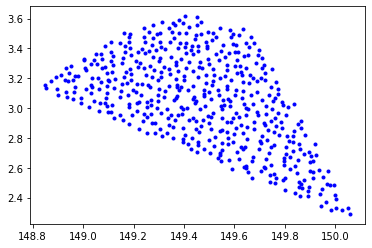

In [77]:
plt.plot(fm["TARGET_RA"],fm["TARGET_DEC"],'b.')

This certainly looks like one petal to me.  Let's repeat, color coding by spectrograph number.

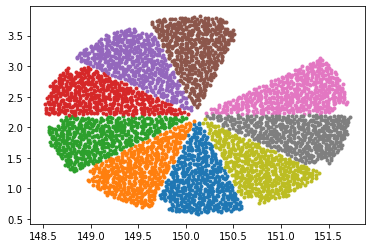

In [80]:
for petal in [0,1,2,3,4,5,7,8,9]:
    coadfilename = coadd_pathname_template.format(spectrograph=petal, tileid=tile, night=last_night)
    fm = fitsio.read(coadfilename, 'FIBERMAP')
    plt.plot(fm["TARGET_RA"],fm["TARGET_DEC"], '.')

In [84]:
for spectrograph in [0,1,2,3,4,5,7,8,9]:
    coadfilename = coadd_pathname_template.format(spectrograph=spectrograph, tileid=tile, night=last_night)
    coadd = fits.open(coadfilename)
    for camera in ['B','R','Z']:
        wave = coadd[f'{camera}_WAVELENGTH'].data
        print("wavelength coverage of camera {}{}: {:.1f} to {:.1f} Angstroms".format(camera.lower(), spectrograph, 
                                                                                            np.min(wave), np.max(wave)))

wavelength coverage of camera b0: 3600.0 to 5800.0 Angstroms
wavelength coverage of camera r0: 5760.0 to 7620.0 Angstroms
wavelength coverage of camera z0: 7520.0 to 9824.0 Angstroms
wavelength coverage of camera b1: 3600.0 to 5800.0 Angstroms
wavelength coverage of camera r1: 5760.0 to 7620.0 Angstroms
wavelength coverage of camera z1: 7520.0 to 9824.0 Angstroms
wavelength coverage of camera b2: 3600.0 to 5800.0 Angstroms
wavelength coverage of camera r2: 5760.0 to 7620.0 Angstroms
wavelength coverage of camera z2: 7520.0 to 9824.0 Angstroms
wavelength coverage of camera b3: 3600.0 to 5800.0 Angstroms
wavelength coverage of camera r3: 5760.0 to 7620.0 Angstroms
wavelength coverage of camera z3: 7520.0 to 9824.0 Angstroms
wavelength coverage of camera b4: 3600.0 to 5800.0 Angstroms
wavelength coverage of camera r4: 5760.0 to 7620.0 Angstroms
wavelength coverage of camera z4: 7520.0 to 9824.0 Angstroms
wavelength coverage of camera b5: 3600.0 to 5800.0 Angstroms
wavelength coverage of c

## Reading in and Displaying spectra

Now that we understand the Data Model, let's plot some spectra. To start, let's use the file we've already been manipulating (for spectrograph 0) and read in the flux to go with the wavelengths we already have.

In [87]:
coadfilename = coadd_pathname_template.format(spectrograph=example_spectrograph, tileid=tile, night=last_night)
wave,flux = dict(), dict()
hdu = fits.open(coadfilename)
for cam in ['b','r','z']:
    wave[cam] = hdu[f'{cam.upper()}_WAVELENGTH'].data
    flux[cam] = hdu[f'{cam.upper()}_FLUX'].data

Note that the wavelength arrays are 1-D (every spectrum in the spectral file is mapped to the same binning in wavelength) but the flux array (and flux_ivar, mask etc. arrays) are 2-D, because they contain multiple spectra:

In [88]:
for cam in ['b','r','z']:
    print(f'For camera {cam}: wave has shape {wave[cam].shape}; flux has shape {flux[cam].shape}')

For camera b: wave has shape (2751,); flux has shape (500, 2751)
For camera r: wave has shape (2326,); flux has shape (500, 2326)
For camera z: wave has shape (2881,); flux has shape (500, 2881)


Let's plot one of the spectra from this file:

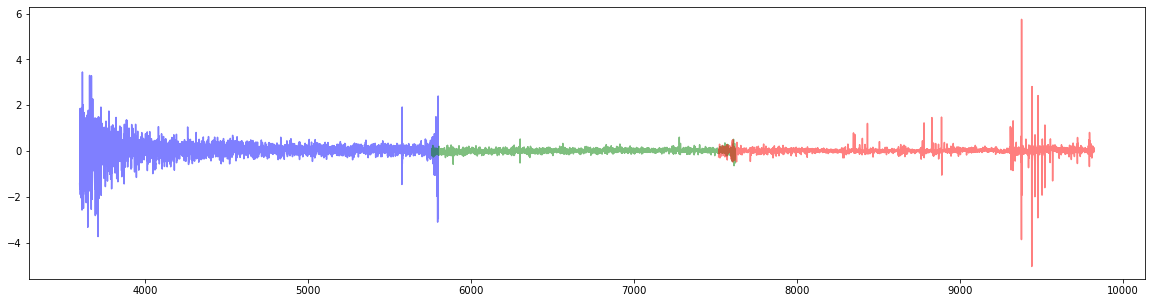

In [104]:
spectrum = 22
# ADM make the figure 20-by-5 in size.
plt.figure(figsize=(20, 5))
# ADM some reasonable plot limits.
#xmin, xmax, ymin, ymax = np.min(wave['b']), np.max(wave['z']), np.min(flux['b'][spectrum][0:100]), np.max(flux[spectrum][0:100])
#plt.axis([xmin, xmax, ymin, ymax])
for cam, color in zip(['b','r','z'], ['b','g','r']):
    plt.plot(wave[cam], flux[cam][spectrum], color+'-', alpha=0.5)

## A DESI-specific spectrum reader

Note that, for illustrative purposes, we discussed the Data Model in detail and read in the required files individually from that Data Model. But, the DESI data team has also developed standalone functions in `desispec.io` to facilitate reading in the plethora of information in the spectral files. For example:

In [95]:
coadd_obj = desispec.io.read_spectra(coadfilename)

INFO:spectra.py:285:read_spectra: iotime 0.801 sec to read coadd-4-80871-thru20210430.fits at 2023-03-04T17:33:40.738493


The wavelengths and flux in each band are then available as dictionaries in the `wave` and `flux` attributes:

In [96]:
coadd_obj.wave

{'b': array([3600. , 3600.8, 3601.6, ..., 5798.4, 5799.2, 5800. ]),
 'r': array([5760. , 5760.8, 5761.6, ..., 7618.4, 7619.2, 7620. ]),
 'z': array([7520. , 7520.8, 7521.6, ..., 9822.4, 9823.2, 9824. ])}

In [97]:
coadd_obj.flux

{'b': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.07453859, -1.5462172 , -3.23765755, ..., -2.5877676 ,
         -0.51054841,  1.2664485 ],
        [ 0.7869072 , -2.62821555,  3.94957399, ...,  1.70153356,
          2.57382607, -2.10913706],
        ...,
        [ 2.60031319,  1.65178561, -2.48301053, ...,  0.35018238,
          0.66968262,  2.23074389],
        [ 1.23500812, -3.53161001, -0.7153616 , ...,  0.27079782,
          2.8838985 , -3.18690658],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 'r': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.11800025,  0.38265586,  0.02799232, ..., -0.04160105,
         -0.33956781,  0.12789457],
        [-0.18580052,  0.09917803, -0.05123813, ..., -0.34801504,
          0.26658636,  0.2833721 ],
        ...,
        [ 0.29840627,  0.04659406,  0.279188

So, to plot the (zeroth-indexed) 23rd spectrum:

In [99]:
def plot_brz(coadd_obj, index):
    for cam, color in zip(['b','r','z'], ['b','g','r']):
        plt.plot(coadd_obj.wave[cam], coadd_obj.flux[cam][index], color+'-', alpha=0.5)

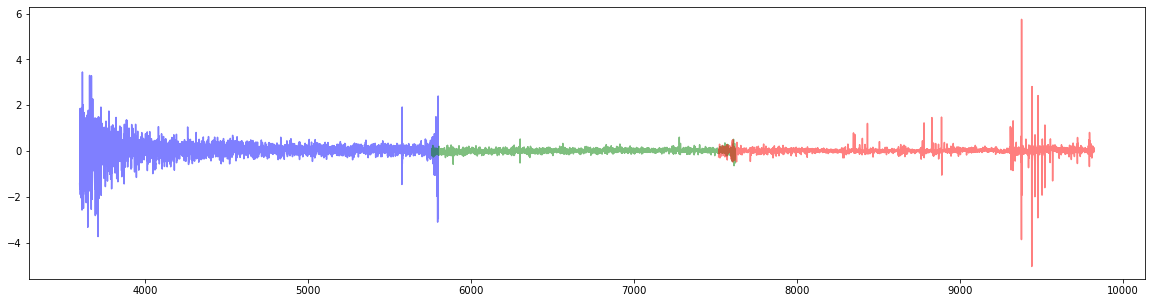

In [102]:
spectrum = 22
# ADM make the figure 20-by-5 in size.
plt.figure(figsize=(20, 5))
# ADM some reasonable plot limits.
#xmin, xmax, ymin, ymax = np.min(wave['b']), np.max(wave['z']), np.min(flux['b'][spectrum][0:100]), np.max(flux[spectrum][0:100])
#plt.axis([xmin, xmax, ymin, ymax])       
plot_brz(coadd_obj, index=spectrum)

which should look very similar to one of the first plots we made earlier in the tutorial. 

The fibermap information is available as a table in the `fibermap` attribute:

In [106]:
coadd_obj.fibermap

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32
616088624076685875,4,519,4519,2000,512,149.18577764486258,3.4954456758443753,0.0,0.0,0.0,5400.0,4294967296,4,SKY,236.08904,328.7954,-1,0.9892023264438604,63,9010,1490p035,351121,563,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0024345953,-0.02085326,-0.07949285,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,-1,-1,0,0,0,0,4294967296,0,0,149.18577764486258,3.4954456758443753,80871,0,0.0,0,0,3.438842,3.513489,-2.9959474,3.2995226,149.19942963766866,9.825844,3.5071576346569167,18.449245,0.0,232.66795,331.7627
234569173303296,4,488,4488,2001,0,149.18344291754704,3.4438559432489413,0.0,0.0,2021.2006,5400.0,4611686018427387904,1,TGT,236.19865,315.03973,3900,0.8546922300706357,1,0,,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,3900,1,4611686018427387904,0,0,9007199254740992,0,0,0,149.18344291754704,3.4438559432489413,80871,19,20620.998,5,1,-0.0010526315,0.007497368,0.002,0.005628873,149.1834385897228,0.10390178,3.4438482596713937,0.07253141,0.7928843,236.21484,315.00735
243353199312918,4,257,4257,2002,0,149.10025673552465,2.9702446361864947,0.0,0.0,2021.2006,5400.0,4611686018427387904,1,TGT,254.03099,192.65988,3800,0.8984058808953498,1,0,,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,3800,1,4611686018427387904,0,0,36028797018963968,0,0,0,149.10025673552465,2.9702446361864947,80871,19,20620.998,5,1,0.0016315789,0.006460406,0.0027894736,0.0069849463,149.10026282342986,0.08709663,2.9702338294316446,0.09020896,0.79250747,254.02731,192.63069
616088612009673219,4,275,4275,2003,0,149.06134266028803,2.9782739995098897,0.0,0.0,0.0,5400.0,4294967296,4,SKY,264.1426,194.98787,-1,0.9885170370719369,63,9010,1491p030,348244,515,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0016216923,-0.01869356,-0.050733484,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,-1,-1,0,0,0,0,4294967296,0,0,149.06134266028803,2.9782739995098897,80871,19,20620.998,5,1,-0.001368421,0.007967037,0.0016842105,0.0066885604,149.06133720696351,0.109362684,2.9782672372413295,0.09139272,0.7926316,264.14148,194.95827
238955152801838,4,296,4296,2004,0,149.14786207311158,3.0706327424951443,0.0,0.0,2021.2006,5400.0,4611686018427387904,1,TGT,242.40004,217.95734,3700,0.9896031553228655,1,0,,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,3700,1,4611686018427387904,0,0,18014398509481984,0,0,0,14

In [105]:
coadd_obj.target_ids()

616088624076685875
234569173303296
243353199312918
616088612009673219
238955152801838
238967224008896
616088612009673464
243359234916383
243353199312914
243353199312940
243365270519818


There are also functions for getting the number of spectra and selecting a subset of spectra.  All of the information that could be read in from the different extensions of the spectral file can be retrieved from the `coadd_obj` object. Here's what's available:

In [107]:
dir(coadd_obj)

['R',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bands',
 '_ftype',
 '_get_slice',
 '_single',
 'bands',
 'exp_fibermap',
 'extra',
 'extra_catalog',
 'fibermap',
 'flux',
 'ftype',
 'ivar',
 'mask',
 'meta',
 'num_spectra',
 'num_targets',
 'resolution_data',
 'scores',
 'scores_comments',
 'select',
 'target_ids',
 'update',
 'wave',
 'wavelength_grid']

## Target classes

What about if we only want to plot spectra of certain target classes? Each survey has it's own targeting and targeting bitmasks. What is relevant here is SV1, since we're looking at an SV1 survey tile:

In [112]:
coadd_obj.fibermap["SV1_DESI_TARGET"].info

name = SV1_DESI_TARGET
dtype = int64
class = Column
n_bad = 0
length = 500

and which target corresponds to which targeting bit is stored in the commisioning (cmx) mask (we imported this near the beginning of the notebook).

In [113]:
sv1_targetmask.desi_mask

sv1_desi_mask:
  - [LRG,              0, "LRG", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MORE_ZGOOD': 3200}, 'numobs': 2}]
  - [ELG,              1, "ELG", {'obsconditions': 'DARK|GRAY', 'priorities': {'UNOBS': 3000, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3000, 'MORE_ZGOOD': 3000}, 'numobs': 1}]
  - [QSO,              2, "QSO", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3400, 'MORE_ZGOOD': 3350, 'MORE_ZWARN': 3300, 'MORE_MIDZQSO': 100, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0}, 'numobs': 4}]
  - [LRG_OPT,          3, "LRG from baseline version of optical cuts", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MORE_ZGOOD': 3200}, 'numobs': 4}]
  - [LRG_IR,           4, "LRG from baseline version of IR cuts", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MO

Each bitmask just assigns bits in an integer to specific categories. 

If you look at the printout above, you'll see STD_FAINT is bit 33 and STD_BRIGHT is bit 35.

Let's verify:

In [114]:
print(sv1_targetmask.desi_mask.mask("STD_FAINT"),sv1_targetmask.desi_mask.mask("STD_BRIGHT"),
      sv1_targetmask.desi_mask.mask("STD_FAINT|STD_BRIGHT"))
print(2**33, 2**35, 2**33 + 2**35)

8589934592 34359738368 42949672960
8589934592 34359738368 42949672960


Let's find the indexes of all standard stars in the spectral file:

In [118]:
coadd_obj.fibermap.colnames

['TARGETID',
 'PETAL_LOC',
 'DEVICE_LOC',
 'LOCATION',
 'FIBER',
 'COADD_FIBERSTATUS',
 'TARGET_RA',
 'TARGET_DEC',
 'PMRA',
 'PMDEC',
 'REF_EPOCH',
 'LAMBDA_REF',
 'FA_TARGET',
 'FA_TYPE',
 'OBJTYPE',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y',
 'PRIORITY',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'RELEASE',
 'BRICKNAME',
 'BRICKID',
 'BRICK_OBJID',
 'MORPHTYPE',
 'EBV',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'MASKBITS',
 'SERSIC',
 'SHAPE_R',
 'SHAPE_E1',
 'SHAPE_E2',
 'REF_ID',
 'REF_CAT',
 'GAIA_PHOT_G_MEAN_MAG',
 'GAIA_PHOT_BP_MEAN_MAG',
 'GAIA_PHOT_RP_MEAN_MAG',
 'PARALLAX',
 'PHOTSYS',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'SV1_DESI_TARGET',
 'SV1_BGS_TARGET',
 'SV1_MWS_TARGET',
 'SV1_SCND_TARGET',
 'DESI_TARGET',
 'BGS_TARGET',
 'MWS_TARGET',
 'PLATE_RA',
 'PLATE_DEC',
 'TILEID',
 'COADD_NUME

In [119]:
isgood = (coadd_obj.fibermap["COADD_FIBERSTATUS"] == 0)
isstdstar = ( (coadd_obj.fibermap["SV1_DESI_TARGET"] & sv1_targetmask.desi_mask.mask("STD_FAINT|STD_BRIGHT")) > 0 )
stds = np.where(isgood & isstdstar)[0]
print(stds)

[ 18  92 100 124 163 201 261 288 290 327 349 354 359 410 413 475 478]


Where were these located on the original plate-fiber mapping?

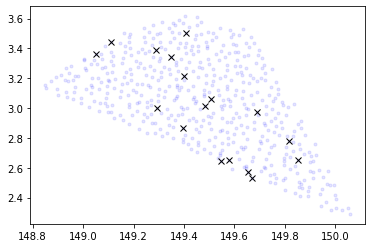

In [120]:
fm = coadd_obj.fibermap   #- shorthand
plt.plot(fm["TARGET_RA"],fm["TARGET_DEC"],'b.', alpha=0.1)
plt.plot(fm["TARGET_RA"][stds],fm["TARGET_DEC"][stds],'kx')

Let's take a look at the spectra of the first 9 of these standard stars.

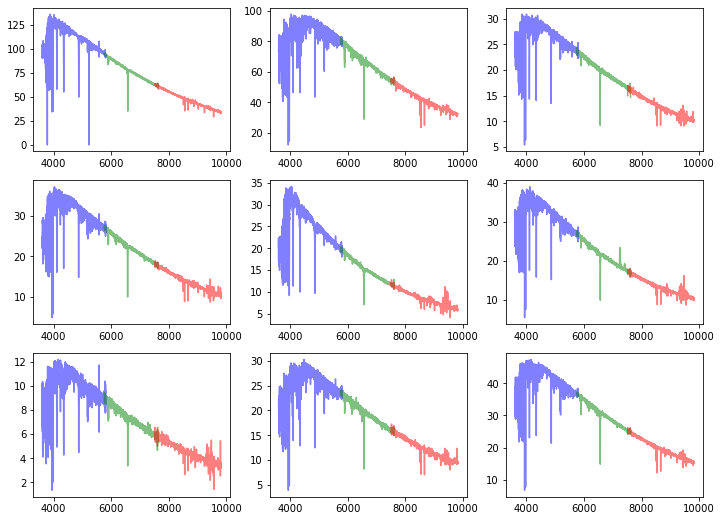

In [121]:
print()
figure(figsize=(12, 9))
for panel, std in enumerate(stds[:9]):
    subplot(3, 3, panel+1)
    plot_brz(coadd_obj, index=std)

These seem star-like. Let's zoom in on some of the Balmer series for the zeroth standard:

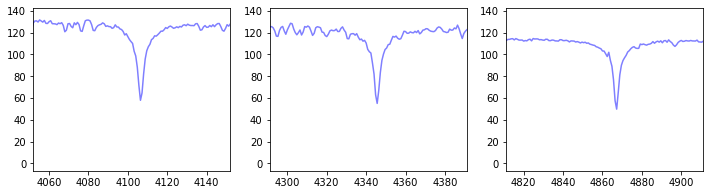

In [122]:
Balmer = [4102, 4341, 4861]
halfwindow = 50
figure(figsize=(4*len(Balmer), 3))
for i in range(len(Balmer)):
    subplot(1, len(Balmer), i+1)
    plt.xlim(Balmer[i]-halfwindow, Balmer[i]+halfwindow)
    plot_brz(coadd_obj, index=stds[0])
    # plt.show()

## Redshifts

The directory from which we took these spectra also contains information on the best-fit redshifts for the spectra from the [redrock](https://github.com/desihub/redrock) code.

In [124]:
zfilename = coadfilename.replace('coadd', 'redrock')
zs = fitsio.read(zfilename)
zs.dtype.descr

[('TARGETID', '>i8'),
 ('Z', '>f8'),
 ('ZERR', '>f8'),
 ('ZWARN', '>i8'),
 ('CHI2', '>f8'),
 ('COEFF', '>f8', (10,)),
 ('NPIXELS', '>i8'),
 ('SPECTYPE', '<U6'),
 ('SUBTYPE', '<U20'),
 ('NCOEFF', '>i8'),
 ('DELTACHI2', '>f8')]

As a sanity check, let's ensure that there are the same number of redshifts, targets, and spectra in the files.

In [125]:
print(zs.shape[0], 'redshifts')
print(coadd_obj.num_targets(), 'targets')
print(coadd_obj.num_spectra(), 'spectra')
print(coadd_obj.flux['b'].shape, 'shape of flux["b"]')

500 redshifts
500 targets
500 spectra
(500, 2751) shape of flux["b"]


Seems logical: 5000 DESI fibers, 10 petals, so 500 entries per petal.

The `TARGETID` (which is intended to be unique for each source) is useful for mapping source spectra to redshift. Let's extract all sources that were targeted as SV-like quasars in `SV1_DESI_TARGET` with bit `QSO`; not to be confused with the Main-Survey-like quasars that were targeted as `QSO` in `DESI_TARGET`) using the fibermap information from the spectral file, and plot the first 20.

1 QSOs


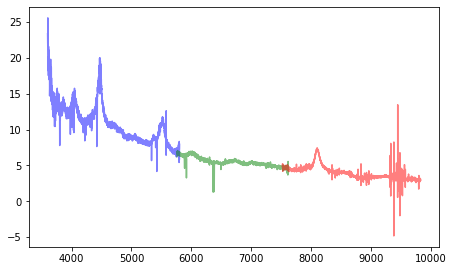

In [128]:
isgood = (coadd_obj.fibermap["COADD_FIBERSTATUS"] == 0)
isQSO = ((coadd_obj.fibermap["SV1_DESI_TARGET"] & sv1_targetmask.desi_mask.mask("QSO")) > 0)
qsos = np.where(isgood & isQSO)[0]
print(len(qsos), 'QSOs')
plt.figure(figsize=(25,15))
for i in range(len(qsos))[0:9]:
    plt.subplot(3,3,i+1)
    plot_brz(coadd_obj,index=qsos[i])


I definitely see some broad emission lines! Let's match these quasar targets to the redshift file on `TARGETID` to extract their best-fit redshifts from `redrock`:

In [130]:
dd = defaultdict(list)
for index, item in enumerate(zs["TARGETID"]):
    dd[item].append(index)
zqsos = [index for item in fm[qsos]["TARGETID"] for index in dd[item] if item in dd]

That might be hard to follow at first glance, but all I did was use some "standard" python syntax to match the indices in `zs` (the ordering of objects in the `redrock` redshift file) to those for quasars in `fm` (the ordering of quasars in the fibermap file), on the unique `TARGETID`, such that the indices stored in `qsos` for `fm` point to the corresponding indices in `zqsos` for `zs`. This might help illustrate the result:

In [46]:
zs[zqsos]["TARGETID"][0:7], np.array(fm[qsos]["TARGETID"][0:7])

(array([39628511505288932, 39628511505289778, 39628511509482314,
        39628516655891670, 39628516655892612, 39628516655893158,
        39628516655893548]),
 array([39628511505288932, 39628511505289778, 39628511509482314,
        39628516655891670, 39628516655892612, 39628516655893158,
        39628516655893548]))

Let's see what best-fit template `redrock` assigned to each quasar target. This information is stored in the `SPECTYPE` column.

In [47]:
zs[zqsos]["SPECTYPE"]

array(['GALAXY', 'GALAXY', 'STAR', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY',
       'STAR', 'GALAXY', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY',
       'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'STAR',
       'GALAXY', 'QSO', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY',
       'GALAXY', 'STAR', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY',
       'STAR', 'QSO', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY',
       'QSO', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY',
       'GALAXY', 'QSO', 'GALAXY', 'QSO', 'GALAXY', 'STAR', 'GALAXY',
       'QSO', 'QSO', 'GALAXY', 'QSO', 'STAR', 'QSO', 'GALAXY', 'GALAXY',
       'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY',
       'GALAXY', 'GALAXY', 'GALAXY', 'STAR', 'GALAXY', 'GALAXY', 'QSO',
       'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY', 'QSO', 'QSO',
       'GALAXY', 'STAR', 'GALAXY', 'GALAXY', 'QSO', 'QSO', 'GALAXY',
       'GALAXY', 'QSO', 'QSO', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY',
       'G

Or for standard stars:

In [48]:
dd = defaultdict(list)
for index, item in enumerate(zs["TARGETID"]):
    dd[item].append(index)
zstds = [index for item in fm[stds]["TARGETID"] for index in dd[item] if item in dd]

For stars, we can also display the type of star that `redrock` fit (this is stored in the `SUBTYPE` column):

In [49]:
for sub, spec in zip(zs[zstds]["SUBTYPE"][10:15], zs[zstds]["SPECTYPE"][10:15]):
    print("{}-{}".format(sub,spec))

G-STAR
G-STAR
G-STAR
G-STAR
G-STAR


Here, I just picked 5 correctly identified stars as an example. 

OK, back to our quasars. Let's plot the quasar targets that *are identified as quasars* , but add a label for the `SPECTYPE` and the redshift fit by `redrock`. I'll also add some median filtering and over-plot some (approximate) typical quasar emission lines at the redrock redshift (if those lines would fall in the DESI wavelength coverage):

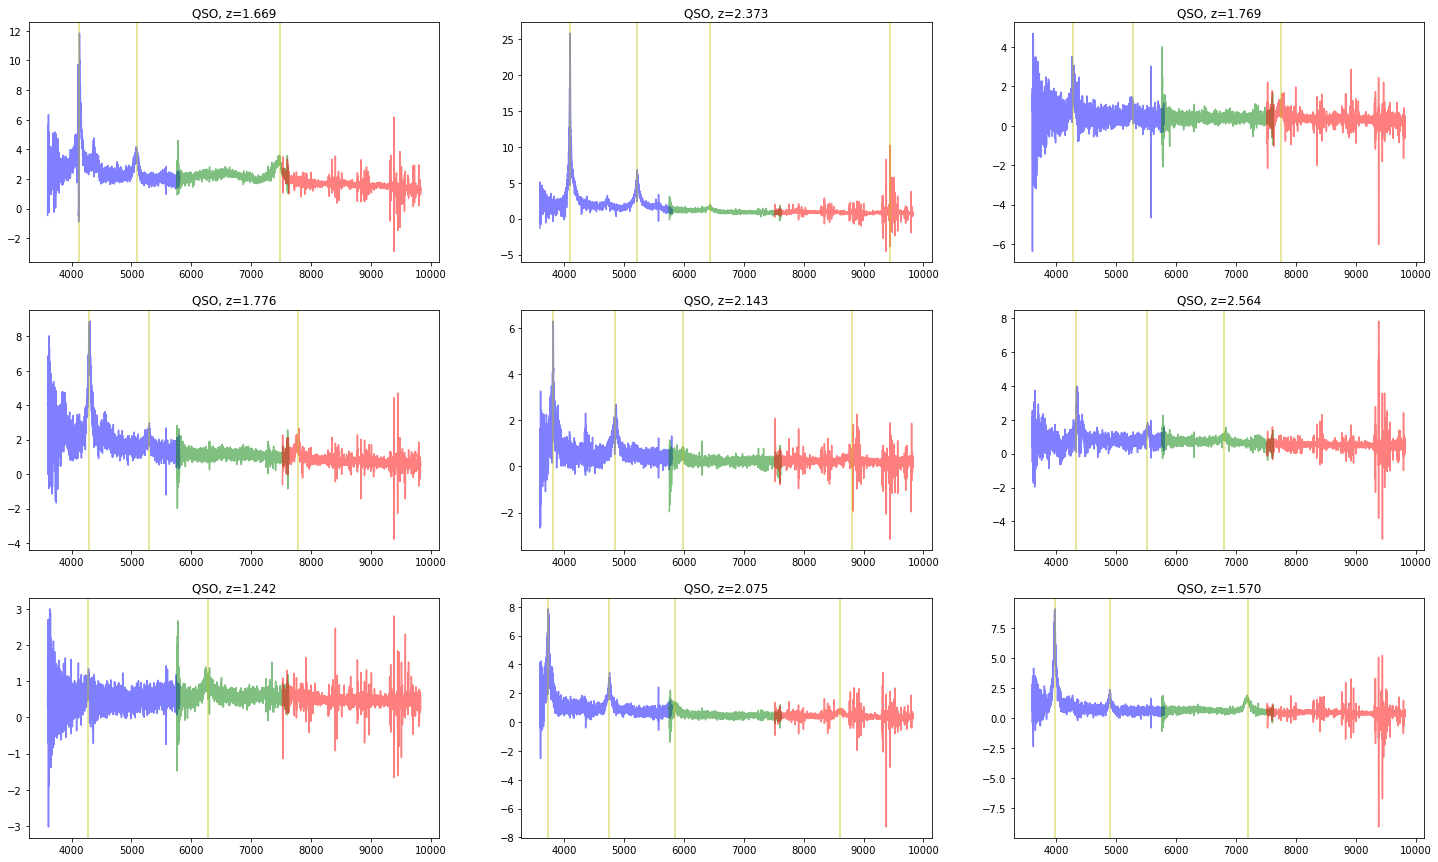

In [50]:
from scipy.signal import medfilt

qsoid = np.where( (zs["DELTACHI2"][zqsos] > 25) & (zs["ZWARN"][zqsos] == 0) & 
                  (zs["SPECTYPE"][zqsos] == 'QSO')       )[0]
qsolines = np.array([1216, 1546, 1906, 2800, 4853, 4960, 5008])

plt.figure(figsize=(25, 15))
for i in range(9):
    plt.subplot(3,3,1+i)
    spectype = zs[zqsos[qsoid[i]]]["SPECTYPE"]
    z = zs[zqsos[qsoid[i]]]["Z"]
    plot_brz(coadd_obj, index=qsos[qsoid[i]])
    plt.title("{}, z={:.3f}".format(spectype,z))
    for line in qsolines:
        if ((1+z)*line > np.min(coadd_obj.wave["b"])) & ((1+z)*line < np.max(coadd_obj.wave["z"])):
            axvline((1+z)*line, color='y', alpha=0.5)